In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from typing import Dict

from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet50
from tqdm import tqdm

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from prettytable import PrettyTable
from pathlib import Path

C:\Users\peter\AppData\Roaming\Python\Python38\site-packages\l5kit\dataset\select_agents.py:31: UserWarning: Windows detected. BLOSC_NOLOCK has not been set as it causes memory leaks on Windows.However, writing the mask with this config may be inconsistent.
  warnings.warn(


In [2]:
import l5kit
print(l5kit.__version__)

1.5.0


In [3]:
cfg = load_config_data("LSTM_CNN.yaml")
os.environ["L5KIT_DATA_FOLDER"] = "../../../../../prediction-dataset/"
dm = LocalDataManager(None)

In [4]:
from l5kit.data import ChunkedDataset

rasterizer = build_rasterizer(cfg, dm)

train_dataset_path = dm.require(cfg['train_data_loader']['key'])
train_zarr_dataset = ChunkedDataset(train_dataset_path).open()
train_dataset = AgentDataset(cfg, train_zarr_dataset, rasterizer)
train_dataloader = DataLoader(train_dataset, shuffle=cfg['train_data_loader']['shuffle'],
                              batch_size=cfg['train_data_loader']['batch_size'], num_workers=cfg['train_data_loader']['num_workers'])

val_dataset_path = dm.require(cfg['val_data_loader']['key'])
val_zarr_dataset = ChunkedDataset(val_dataset_path).open()
val_dataset = AgentDataset(cfg, val_zarr_dataset, rasterizer)
val_dataloader = DataLoader(val_dataset, shuffle=cfg['val_data_loader']['shuffle'],
                            batch_size=cfg['val_data_loader']['batch_size'], num_workers=cfg['val_data_loader']['num_workers'])

test_dataset_path = dm.require(cfg['test_data_loader']['key'])
test_zarr_dataset = ChunkedDataset(test_dataset_path).open()
test_dataset = AgentDataset(cfg, test_zarr_dataset, rasterizer)
test_dataloader = DataLoader(test_dataset, shuffle=cfg['test_data_loader']['shuffle'],
                             batch_size=cfg['test_data_loader']['batch_size'], num_workers=cfg['test_data_loader']['num_workers'])


In [5]:
class MultiTrajectoryModel(nn.Module):
    def __init__(self, cfg: Dict, num_modes=3):
        super().__init__()

        self.backbone = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
        num_history_channels = (cfg["model_params"]["history_num_frames"] + 1) * 2
        num_in_channels = 3 + num_history_channels
        self.backbone.conv1 = nn.Conv2d(
            num_in_channels,
            self.backbone.conv1.out_channels,
            kernel_size=self.backbone.conv1.kernel_size,
            stride=self.backbone.conv1.stride,
            padding=self.backbone.conv1.padding,
            bias=False,
        )
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])

        self.num_modes = num_modes
        self.num_targets = 2 * cfg["model_params"]["future_num_frames"]

        # Calculate the output features of the backbone
        input_shape = (num_in_channels, cfg["raster_params"]["raster_size"][1], cfg["raster_params"]["raster_size"][0])
        backbone_out_features = self.backbone_out_features(input_shape)

        self.fc = nn.Linear(backbone_out_features, self.num_targets * num_modes + num_modes)

    def backbone_out_features(self, input_shape):
        with torch.no_grad():
            x = torch.zeros(1, *input_shape)
            x = self.backbone(x)
            _, C, H, W = x.shape
            return C * H * W

    def forward(self, x):
        x = self.backbone(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)

        bs, _ = x.shape
        output_features = x.shape[1] - self.num_modes
        self.num_targets = output_features // (self.num_modes * 2)
        pred, confidences = x.split([self.num_modes * self.num_targets * 2, self.num_modes], dim=1)
        pred = pred.view(bs, self.num_modes, self.num_targets, 2)
        confidences = torch.softmax(confidences, dim=1)
        return pred, confidences




In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MultiTrajectoryModel(cfg).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.MSELoss(reduction="none")

Using cache found in C:\Users\peter/.cache\torch\hub\pytorch_vision_v0.6.0
c:\Users\peter\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\peter\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for i, data in enumerate(train_dataloader):
        inputs, targets = data['image'].to(device), data['target_positions'].to(device)
        optimizer.zero_grad()
        preds, confidences = model(inputs)
        loss = torch.mean(torch.sum(torch.mean(criterion(targets.unsqueeze(1).repeat(1, 3, 1, 1), preds), dim=3), dim=2), dim=1)
        weighted_loss = torch.einsum('i,ij->', loss, confidences)
        weighted_loss.backward()
        optimizer.step()
        train_losses.append(weighted_loss.item())
        if (i + 1) % 100 == 0:
            print(f"Epoch: {epoch + 1}/{num_epochs}, Batch: {i + 1}/{len(train_dataloader)}, Loss: {weighted_loss.item()}")

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {np.mean(train_losses)}")

Epoch: 1/1, Batch: 100/6978, Loss: 56284.98828125
Epoch: 1/1, Batch: 200/6978, Loss: 7227.6689453125
Epoch: 1/1, Batch: 300/6978, Loss: 9825.8984375
Epoch: 1/1, Batch: 400/6978, Loss: 6863.912109375
Epoch: 1/1, Batch: 500/6978, Loss: 11293.802734375
Epoch: 1/1, Batch: 600/6978, Loss: 29265.900390625
Epoch: 1/1, Batch: 700/6978, Loss: 47846.4296875
Epoch: 1/1, Batch: 800/6978, Loss: 29932.958984375
Epoch: 1/1, Batch: 900/6978, Loss: 52798.3359375
Epoch: 1/1, Batch: 1000/6978, Loss: 10153.3857421875
Epoch: 1/1, Batch: 1100/6978, Loss: 24585.705078125
Epoch: 1/1, Batch: 1200/6978, Loss: 6564.8359375
Epoch: 1/1, Batch: 1300/6978, Loss: 2709.645751953125
Epoch: 1/1, Batch: 1400/6978, Loss: 34981.9609375
Epoch: 1/1, Batch: 1500/6978, Loss: 21480.46484375
Epoch: 1/1, Batch: 1600/6978, Loss: 5399.2734375
Epoch: 1/1, Batch: 1700/6978, Loss: 9951.1591796875
Epoch: 1/1, Batch: 1800/6978, Loss: 11958.4580078125
Epoch: 1/1, Batch: 1900/6978, Loss: 8809.060546875
Epoch: 1/1, Batch: 2000/6978, Loss: 

In [ ]:
torch.save(model.state_dict(), "model.pth")

In [11]:
model.eval()
predictions = []

with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        inputs = data['image'].to(device)
        preds, confidences = model(inputs)
        preds = preds.cpu().numpy()
        confidences = confidences.cpu().numpy()
        world_from_agents = data['world_from_agent'].numpy()
        centroids = data['centroid'].numpy()
        for idx in range(len(preds)):
            pred = preds[idx]
            confidence = confidences[idx]
            for mode in range(len(confidence)):
                coords_offset = pred[mode]
                coords = transform_points(coords_offset, world_from_agents[idx]) - centroids[idx][:2]
                predictions.append((data["track_id"][idx], data["timestamp"][idx], coords, mode, confidence[mode]))
        if (i + 1) % 100 == 0:
            print(f"Batch: {i + 1}/{len(test_dataloader)}")
        

write_pred_csv('multi_trajectory_predictions.csv', predictions)

Batch: 100/27909
Batch: 200/27909
Batch: 300/27909
Batch: 400/27909
Batch: 500/27909
Batch: 600/27909
Batch: 700/27909
Batch: 800/27909
Batch: 900/27909
Batch: 1000/27909
Batch: 1100/27909
Batch: 1200/27909
Batch: 1300/27909
Batch: 1400/27909
Batch: 1500/27909
Batch: 1600/27909
Batch: 1700/27909
Batch: 1800/27909
Batch: 1900/27909
Batch: 2000/27909
Batch: 2100/27909
Batch: 2200/27909
Batch: 2300/27909
Batch: 2400/27909
Batch: 2500/27909
Batch: 2600/27909
Batch: 2700/27909
Batch: 2800/27909
Batch: 2900/27909
Batch: 3000/27909
Batch: 3100/27909
Batch: 3200/27909
Batch: 3300/27909
Batch: 3400/27909
Batch: 3500/27909
Batch: 3600/27909
Batch: 3700/27909
Batch: 3800/27909
Batch: 3900/27909
Batch: 4000/27909
Batch: 4100/27909
Batch: 4200/27909
Batch: 4300/27909
Batch: 4400/27909
Batch: 4500/27909
Batch: 4600/27909
Batch: 4700/27909
Batch: 4800/27909
Batch: 4900/27909
Batch: 5000/27909
Batch: 5100/27909
Batch: 5200/27909
Batch: 5300/27909
Batch: 5400/27909
Batch: 5500/27909
Batch: 5600/27909
B

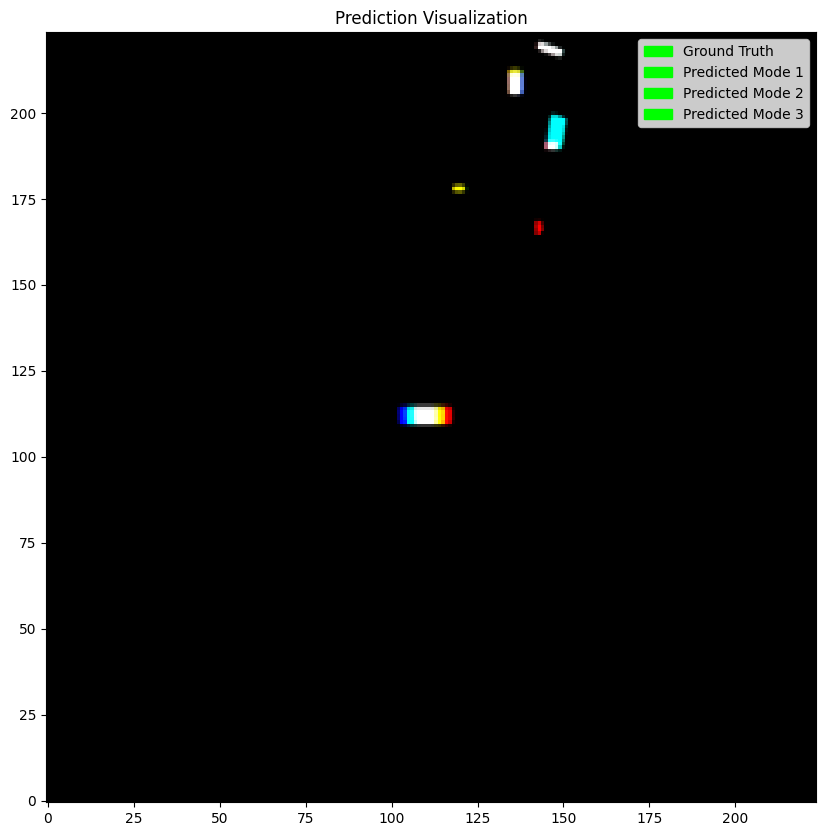

In [ ]:
metrics = compute_metrics_csv("./multi_trajectory_predictions.csv", "./path/to/ground_truth.csv", [neg_multi_log_likelihood, time_displace])
print(metrics)

In [ ]:
# Load ground truth data
gt_data = l5kit.data.LocalDataManager(None).get("scenes/sample.zarr")
gt_agent_dataset = l5kit.dataset.AgentDataset(cfg, gt_data, rasterizer)

def plot_predicted_trajectories(predictions, scene_idx, n_agents=10):
    scene = gt_agent_dataset.rasterizer.to_rgb(gt_agent_dataset[scene_idx]["image"].transpose(1, 2, 0))
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(scene)

    # Filter predictions by scene index
    scene_predictions = [pred for pred in predictions if pred[1] == gt_agent_dataset[scene_idx]["timestamp"]]
    for pred in scene_predictions[:n_agents]:
        track_id, timestamp, coords, mode, confidence = pred
        coords = coords + gt_agent_dataset[scene_idx]["centroid"][:2]
        ax.plot(coords[:, 0], coords[:, 1], label=f"Mode {mode} ({confidence:.2f})")

    ax.set_title(f"Scene {scene_idx}")
    ax.legend(loc="upper right")
    plt.show()

plot_predicted_trajectories(predictions, scene_idx=0, n_agents=10)